In [1]:
%pip install arabic-stopwords

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 7.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import nltk
import string
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.isri import ISRIStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.svm import SVC
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, GridSearchCV
import arabicstopwords.arabicstopwords as ast
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from collections import OrderedDict
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder

In [27]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}
classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

In [3]:
dataset = load_dataset('emotone_ar')

Generating train split:   0%|          | 0/10065 [00:00<?, ? examples/s]

Dataset emotone_ar downloaded and prepared to /root/.cache/huggingface/datasets/emotone_ar/default/0.0.0/36bfa7e8bdf640ccb3d5701933cfde2fa7051f22881cfab2962122771d32c430. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
def normalizeArabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    return(text)

stop_words = ast.stopwords_list()

def remove_stop_words(text):
    return ' '.join(word for word in str(text).split() if word not in stop_words)

arabic_punctuations = '''`÷×؛<>_():*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


# snow_stemmer = SnowballStemmer(language='arabic')
isri_stemmer = ISRIStemmer()

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def stemming(text):
  x = w_tokenizer.tokenize(text)
  # return [snow_stemmer.stem(w) for w in x]
  return [isri_stemmer.stem(w) for w in x]

def prepare_text(text):
  text = normalizeArabic(text)
  text = remove_stop_words(text)
  text = remove_punctuations(text)
  text = stemming(text)
  return text

In [5]:
df = pd.DataFrame(dataset['train'])

In [6]:
df.head()

,tweet,label
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,0
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,1
2,كتنا نيله ف حظنا الهباب xD,3
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,2
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,0


In [7]:
df.isnull().sum()

tweet    0
label    0
dtype: int64

In [8]:
df['label'].value_counts()

0    1550
1    1444
2    1281
3    1256
4    1220
7    1207
5    1062
6    1045
Name: label, dtype: int64

In [9]:
g = df.groupby('label')
df_balanced = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [10]:
df_balanced['original'] = df_balanced['tweet']
df_balanced['data'] = df_balanced['original'].apply(prepare_text)
df_balanced = df_balanced.drop(['tweet'], axis=1)

In [11]:
df_balanced['label'].value_counts()

1    1045
6    1045
0    1045
7    1045
4    1045
5    1045
2    1045
3    1045
Name: label, dtype: int64

<Axes: ylabel='Frequency'>

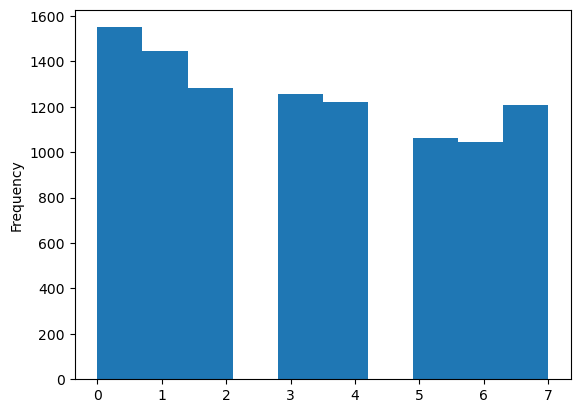

In [12]:
df['label'].plot.hist()

<Axes: ylabel='Frequency'>

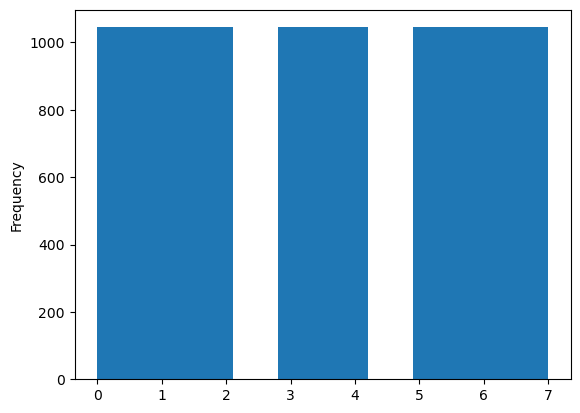

In [13]:
df_balanced['label'].plot.hist()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['data'], df_balanced['label'], test_size=0.2, stratify=df_balanced['label'], random_state=42)

In [15]:
encoder = OneHotEncoder()

y_train = encoder.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_test = encoder.transform(y_test.values.reshape(-1,1)).toarray()

In [16]:
def prepare_tokenization(train, val, test=None, pad=500):
  tokenizer = Tokenizer(oov_token='<UNK>')
  tokenizer.fit_on_texts(train)
  tokenizer.word_index['<PAD>'] = 0
  train = tokenizer.texts_to_sequences(train)
  val = tokenizer.texts_to_sequences(val)
  if not pad==False:
    train = sequence.pad_sequences(train, maxlen=pad)
    val = sequence.pad_sequences(val, maxlen=pad)
  if not type(test)==type(None):
    test = tokenizer.texts_to_sequences(test)
    if not pad==False:
      test = sequence.pad_sequences(test, maxlen=pad)
  v_size = len(tokenizer.word_index)
  print("Vocabulary size={}".format(v_size))
  print("Number of Documents={}".format(tokenizer.document_count))
  if not type(test)==type(None):
    return v_size, train, val, test
  else:
    return v_size, train, val

In [17]:
VOCAB_SIZE, train_sequences, test_sequences = prepare_tokenization(X_train, X_test, pad=False)

Vocabulary size=10225
Number of Documents=6688


(array([ 170.,  904., 1250., 1151., 1102., 1121.,  775.,  185.,   28.,
           2.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

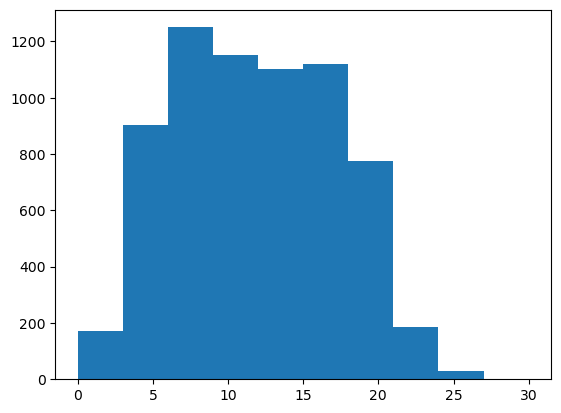

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
plt.hist(train_lens)

In [19]:
max_length = max(train_lens)

In [20]:
max_length

30

In [21]:
X_train = sequence.pad_sequences(train_sequences, maxlen=max_length)
X_test = sequence.pad_sequences(test_sequences, maxlen=max_length)
X_train.shape, X_test.shape

((6688, 30), (1672, 30))

In [22]:
BATCH_SIZE = 128
EPOCHS = 50
EMBED_SIZE = 300
LEARNING_RATE =  0.001

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True)

In [37]:
def create_gru_model(model_type):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_length, trainable=True))
    if model_type==1:
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)))
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)))
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=False)))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='softmax'))
    elif model_type==2:
        model.add(tf.keras.layers.GRU(512, return_sequences=True))
        model.add(tf.keras.layers.GRU(256, return_sequences=True))
        model.add(tf.keras.layers.GRU(128, return_sequences=False))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(8, activation='softmax'))
    elif model_type==3:
        model.add(tf.keras.layers.GRU(128, return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='softmax'))
    elif model_type==4:
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='softmax'))
    elif model_type==5:
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=False)))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='softmax'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # model.summary()

    history = model.fit(X_train, np.asarray(y_train), validation_data=(X_test, np.asarray(y_test)), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_monitor])
    return model, history

In [38]:
for i in range(1,6):
    model, _ = create_gru_model(i)
    predictions = model.predict(X_test)
    print('--------------------------------------------------------')
    print()
    print('CLassification report for model {}: '.format(i))
    print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=classes))
    print()
    print('--------------------------------------------------------')

Epoch 1/50
53/53 [==============================] - 64s 207ms/step - loss: 1.9741 - accuracy: 0.2059 - val_loss: 1.6118 - val_accuracy: 0.3708
Epoch 2/50
53/53 [==============================] - 8s 145ms/step - loss: 1.5965 - accuracy: 0.3847 - val_loss: 1.4071 - val_accuracy: 0.4749
Epoch 3/50
53/53 [==============================] - 6s 107ms/step - loss: 1.3031 - accuracy: 0.5274 - val_loss: 1.2711 - val_accuracy: 0.5377
Epoch 4/50
53/53 [==============================] - 6s 107ms/step - loss: 1.0370 - accuracy: 0.6411 - val_loss: 1.2760 - val_accuracy: 0.5640
Epoch 5/50
53/53 [==============================] - 5s 95ms/step - loss: 0.8091 - accuracy: 0.7376 - val_loss: 1.3699 - val_accuracy: 0.5574
Epoch 6/50
53/53 [==============================] - 5s 88ms/step - loss: 0.6027 - accuracy: 0.8228 - val_loss: 1.5387 - val_accuracy: 0.5754
Epoch 7/50
53/53 [==============================] - 5s 88ms/step - loss: 0.4626 - accuracy: 0.8780 - val_loss: 1.5693 - val_accuracy: 0.5634
Epoch 8/